<a href="https://colab.research.google.com/github/SarangPratap/GenerativeAdversialNetworks-for-covid-images/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2




In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(256,256,3)):
    model = keras.models.Sequential()
    # normal
    model.add(keras.layers.Conv2D(32, (3,3), padding='same', input_shape=in_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # downsample
    model.add(keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # classifier
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
def read_image():
    images = []
    for dir_item in os.listdir('/content/drive/MyDrive/Colab Notebooks/hist_enhanced/normal'):
        full_path = os.path.abspath(os.path.join('/content/drive/MyDrive/Colab Notebooks/hist_enhanced/normal',dir_item))
        image = cv2.imread(full_path)
        #height, width, channels = image.shape
        #print( height, width, channels)
        # image = cv2.resize(image,(32,32))
        images.append(image)
    return images
# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    trainX = read_image()
    trainX =np.array(trainX)
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = X / 255.0
    return X


In [ ]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y


def generate_fake_samples1(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(256* 256 * 3 * n_samples)

    # update to have the range [-1, 1]
    X = -1 + X * 2
    # reshape into a batch of color images
    X = X.reshape((n_samples, 256, 256, 3))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y


In [ ]:

# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples1(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
def test_train_discriminator():
    # define the discriminator model
    model = define_discriminator()
    # load image data
    dataset = load_real_samples()
    # fit the model
    train_discriminator(model, dataset)


In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = keras.models.Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
     # upsample to 256*256
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # output layer
    model.add(keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    
    model.summary()
    return model

In [ ]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y


def show_fake_sample():
    # size of the latent space
    latent_dim = 100
    # define the discriminator model
    model = define_generator(latent_dim)
    # generate samples
    n_samples = 49
    X, _ = generate_fake_samples(model, latent_dim, n_samples)
    # scale pixel values from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the generated samples
    for i in range(n_samples):
        # define subplot
        plt.subplot(7, 7, 1 + i)
        # turn off axis labels
        plt.axis('off')
        # plot single image
        plt.imshow(X[i])
    # show the figure
    plt.show()

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    d_model.trainable = False
    # connect them
    model = tf.keras.models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def show_gan_module():
    # size of the latent space
    latent_dim = 100
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    # summarize gan model
    gan_model.summary()




In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=70, n_batch=20):
    #gan_model.load_weights('generator_model_200.h5',by_name=True)
    # json_string = gan_model.to_json()
    # gan_model = json_string(json_string)
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i + 1, j + 1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)



    



In [ ]:
    # size of the latent space
    latent_dim = 100
    d_model = define_discriminator()
    g_model = define_generator(latent_dim)
   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
    gan_model = define_gan(g_model, d_model)
  
    dataset = load_real_samples()
  
   


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:


# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))
    # save plot
    #save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 200 +1)
    g_model.save(filename)


In [ ]:

train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/50, d1=0.701, d2=0.696 g=0.696
>1, 2/50, d1=0.217, d2=0.691 g=0.707
>1, 3/50, d1=0.024, d2=0.676 g=0.731
>1, 4/50, d1=0.004, d2=0.651 g=0.773
>1, 5/50, d1=0.002, d2=0.615 g=0.845
>1, 6/50, d1=0.001, d2=0.570 g=0.964
>1, 7/50, d1=0.001, d2=0.520 g=1.166
>1, 8/50, d1=0.003, d2=0.444 g=1.722
>1, 9/50, d1=0.179, d2=0.586 g=1.713
>1, 10/50, d1=0.001, d2=0.434 g=4.218
>1, 11/50, d1=0.912, d2=0.473 g=0.868
>1, 12/50, d1=0.000, d2=1.552 g=0.846
>1, 13/50, d1=0.000, d2=1.223 g=1.796
>1, 14/50, d1=0.006, d2=0.232 g=3.190
>1, 15/50, d1=0.356, d2=0.564 g=1.702
>1, 16/50, d1=0.046, d2=1.148 g=2.601
>1, 17/50, d1=1.247, d2=0.943 g=1.475
>1, 18/50, d1=0.208, d2=0.285 g=2.619
>1, 19/50, d1=0.048, d2=0.121 g=2.827
>1, 20/50, d1=0.327, d2=0.228 g=1.674
>1, 21/50, d1=0.027, d2=0.278 g=1.576
>1, 22/50, d1=0.018, d2=0.250 g=1.676
>1, 23/50, d1=0.064, d2=0.208 g=1.851
>1, 24/50, d1=0.005, d2=0.169 g=2.122
>1, 25/50, d1=0.036, d2=0.135 g=2.329
>1, 26/50, d1=0.003, d2=0.119 g=2.555
>1, 27/50, d1=0.004, 

In [ ]:


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

def show_imgs_for_final_generator_model():
    # load model
    model = tf.keras.models.load_model('generator_model_260.h5')
    # generate images
    latent_points = generate_latent_points(100, 100)
    # generate images
    X = model.predict(latent_points)
    # scale from [-1,1] to [0,1]w
    X = (X + 1) / 2.0
    # plot the result
    create_plot(X, 10)

def show_single_imgs():
    model = tf.keras.models.load_model('generator_model_260.h5')
    # all 0s
    vector = np.asarray([[0.75 for _ in range(100)]])
    # generate image
    X = model.predict(vector)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    plt.imshow(X[0, :, :])
    plt.show()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)      

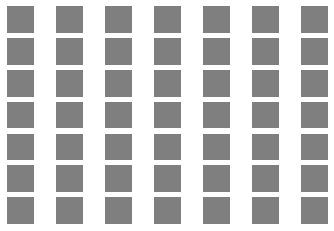

In [ ]:
show_fake_sample()


In [ ]:
show_gan_module()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 256)      

In [ ]:
show_imgs_for_final_generator_model()

In [ ]:
"""if __name__ == '__main__':
    # show_imgs_for_final_generator_model()
    # define_discriminator()
    # test_train_discriminator()
    # show_fake_sample()
    # show_gan_module()
    train_gan()
    # show_imgs_for_final_generator_model()
    # show_single_imgs()
    # res = read_image()
    # print(res[0].shape)"""

In [ ]:
show_single_imgs()
res = read_image()
print(res[0].shape)

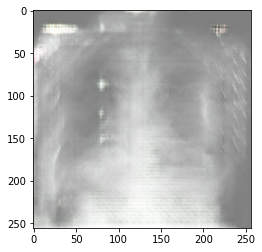

In [ ]:
show_single_imgs()